<a href="https://colab.research.google.com/github/venkatchiranjeevireddy/handwritten_recognition/blob/main/hand_written_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

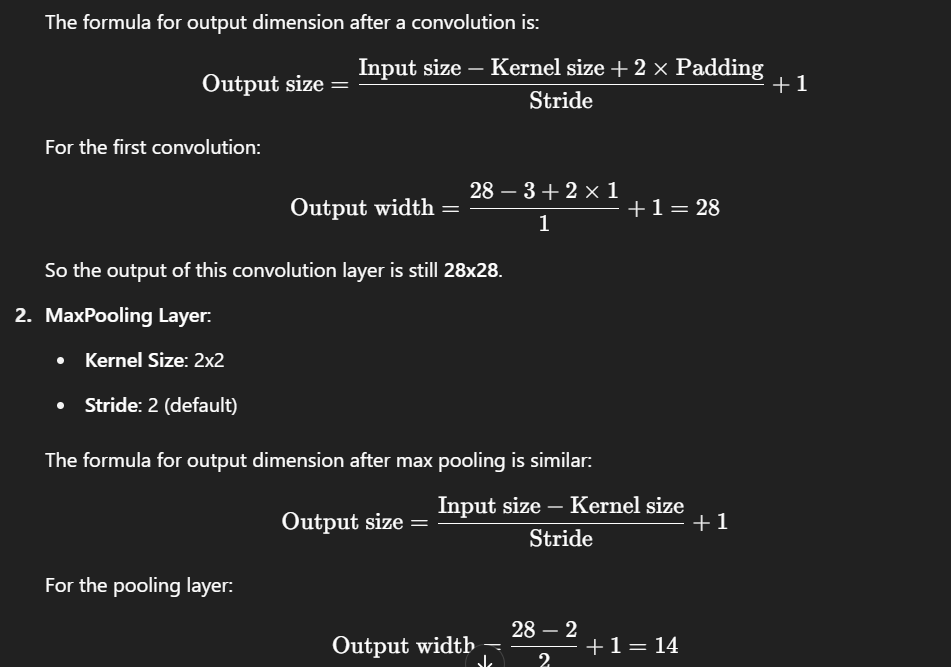

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -------------------- DEVICE --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------- TRANSFORMS --------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# -------------------- LOAD MNIST --------------------
train_digits = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_digits = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

final_train_d = DataLoader(train_digits, batch_size=64, shuffle=True)
final_test_d = DataLoader(test_digits, batch_size=64, shuffle=False)

# -------------------- LOAD EMNIST --------------------
train_letters = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
test_letters = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)

# ✅ FIX LABELS: EMNIST letters range from 1–26, we remap them to 0–25
train_letters.targets = train_letters.targets - 1
test_letters.targets = test_letters.targets - 1

train_letters_d = DataLoader(train_letters, batch_size=64, shuffle=True)
test_letters_d = DataLoader(test_letters, batch_size=64, shuffle=False)

# -------------------- CNN MODEL --------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------- TRAINING FUNCTION --------------------
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# -------------------- EVALUATION FUNCTION --------------------
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return predictions

# -------------------- TRAIN AND EVALUATE DIGITS --------------------
print("\n🎯 Training Digit Classifier (MNIST)")
model_digits = CNNModel(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digits.parameters(), lr=0.001)

train_model(model_digits, final_train_d, criterion, optimizer, epochs=5)
digit_preds = evaluate_model(model_digits, final_test_d)

# -------------------- TRAIN AND EVALUATE LETTERS --------------------
print("\n🔤 Training Letter Classifier (EMNIST)")
model_letters = CNNModel(num_classes=26).to(device)
optimizer = torch.optim.Adam(model_letters.parameters(), lr=0.001)

train_model(model_letters, train_letters_d, criterion, optimizer, epochs=5)
letter_preds = evaluate_model(model_letters, test_letters_d)


Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]
100%|██████████| 562M/562M [00:02<00:00, 244MB/s]



🎯 Training Digit Classifier (MNIST)
Epoch [1/5], Loss: 149.3799, Accuracy: 95.20%
Epoch [2/5], Loss: 42.1591, Accuracy: 98.59%
Epoch [3/5], Loss: 28.7751, Accuracy: 99.06%
Epoch [4/5], Loss: 22.8534, Accuracy: 99.21%
Epoch [5/5], Loss: 16.8598, Accuracy: 99.39%
Test Accuracy: 99.19%

🔤 Training Letter Classifier (EMNIST)
Epoch [1/5], Loss: 854.6866, Accuracy: 86.24%
Epoch [2/5], Loss: 435.6722, Accuracy: 92.52%
Epoch [3/5], Loss: 357.6253, Accuracy: 93.75%
Epoch [4/5], Loss: 303.6941, Accuracy: 94.45%
Epoch [5/5], Loss: 263.5817, Accuracy: 95.02%
Test Accuracy: 93.12%
